# Project

Michael Wendell

Load in required imports for data organization and graphical formatting.

In [1]:
from pathlib import Path
import re

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
from lenskit import topn

In [4]:
import gzip

In [5]:
import seedbank
seedbank.initialize(20230306)
rng = seedbank.numpy_rng()

## Recomendation Evaluation

After all algorithims have been trained and then generated on both the dev and eval set, we can now look at the performance for evaluation.

In [6]:
eval_test = pd.read_parquet('data/a3-eval-actions.parquet')
dev_test = pd.read_parquet('data/a3-dev-actions.parquet')

In [7]:
rla = topn.RecListAnalysis()
rla.add_metric(topn.hit, k=100)
rla.add_metric(topn.ndcg, k=100)
rla.add_metric(topn.recip_rank, k=100)

We want to look at hit rate, nDCG, and reciprocal ranking as forms of evaluation.

### Tuning Parameters
We first want to tune our hybrid recommender to perform better with our metrics, so we can get the best recommendations for the users.

#### Epochs
First, we vary the number of epochs for the algorithm.

In [8]:
recs = {}
_hy_re = re.compile(r'^hybrid-(.*)-(.*)-(dev|eval)\.parquet')
_algo_re = re.compile(r'^(.*)-(dev|eval)\.parquet')
for file in Path('recs_epochs').glob('*.parquet'):
    hm = _hy_re.match(file.name)
    am = _algo_re.match(file.name)
    if hm:
        key = hm.group(1), hm.group(2), hm.group(3)
    elif am:
        key = am.group(1), 'NA', am.group(2)
    else:
        raise ValueError(f'bad name {file.name}')
    recs[key] = pd.read_parquet(file)

In [9]:
recs = pd.concat(recs, names=['algo', 'parts', 'set']).reset_index(['algo', 'parts', 'set']).reset_index(drop=True)
scores = rla.compute(recs, pd.concat([dev_test, eval_test], ignore_index=True), include_missing=True)
scores

nrecs  hit      ndcg  recip_rank  ntruth
algo parts set  user                                             
E1   NA    dev  6046878  100.0  1.0  0.058325    0.033333      13
                117918   100.0  1.0  0.208015    0.035714       1
                4665144  100.0  1.0  0.169992    0.023810       3
                3385905  100.0  0.0  0.000000    0.000000       1
                2896080  100.0  0.0  0.000000    0.000000       1
...                        ...  ...       ...         ...     ...
E7   NA    eval 6229490    0.0  NaN       NaN         NaN       3
                6229534    0.0  NaN       NaN         NaN       3
                6229876    0.0  NaN       NaN         NaN       3
                6230173    0.0  NaN       NaN         NaN       2
                6230389    0.0  NaN       NaN         NaN       2

[400000 rows x 5 columns]

In [10]:
scores = scores.reset_index()

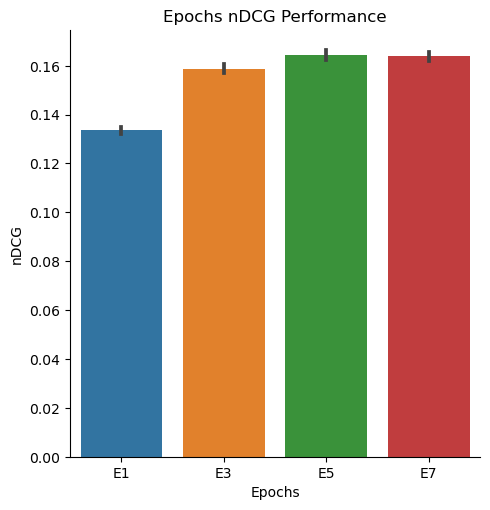

In [16]:
sns.color_palette("Set2")
sns.catplot(scores, x='algo', y='ndcg', kind='bar')
plt.xlabel('Epochs')
plt.ylabel('nDCG')
plt.title('Epochs nDCG Performance')
plt.show()

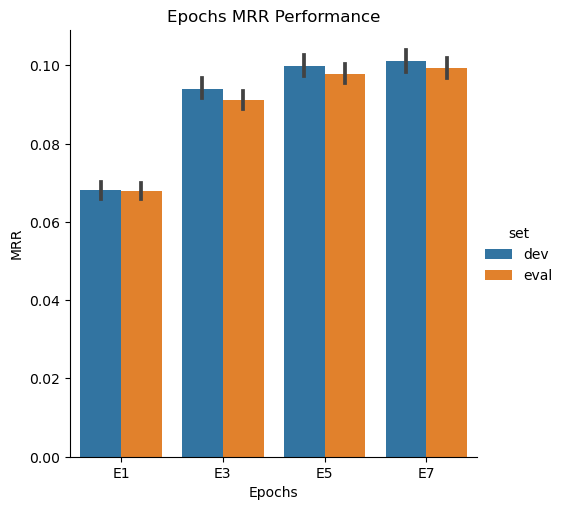

In [17]:
sns.catplot(scores, x='algo', y='recip_rank', hue='set', kind='bar')
plt.xlabel('Epochs')
plt.ylabel('MRR')
plt.title('Epochs MRR Performance')
plt.show()

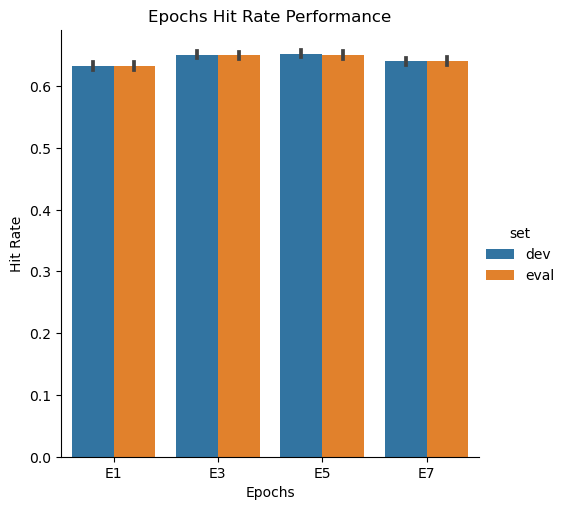

In [18]:
sns.catplot(scores, x='algo', y='hit', hue='set', kind='bar')
plt.xlabel('Epochs')
plt.ylabel('Hit Rate')
plt.title('Epochs Hit Rate Performance')
plt.show()

After reviewing all three plots, we can see that about 5 epochs is where the algorihtm has the best results. Using 7 epochs is close, but it looks like it could be overfitting the training data.

#### Regularization Term
Second, we will vary the regularization.

In [19]:
recs = {}
_hy_re = re.compile(r'^hybrid-(.*)-(.*)-(dev|eval)\.parquet')
_algo_re = re.compile(r'^(.*)-(dev|eval)\.parquet')
for file in Path('recs_reg').glob('*.parquet'):
    hm = _hy_re.match(file.name)
    am = _algo_re.match(file.name)
    if hm:
        key = hm.group(1), hm.group(2), hm.group(3)
    elif am:
        key = am.group(1), 'NA', am.group(2)
    else:
        raise ValueError(f'bad name {file.name}')
    recs[key] = pd.read_parquet(file)

In [20]:
recs = pd.concat(recs, names=['algo', 'parts', 'set']).reset_index(['algo', 'parts', 'set']).reset_index(drop=True)
scores = rla.compute(recs, pd.concat([dev_test, eval_test], ignore_index=True), include_missing=True)
scores

nrecs  hit      ndcg  recip_rank  ntruth
algo   parts set  user                                             
R0.001 NA    dev  6046878  100.0  1.0  0.083326    0.043478      13
                  117918   100.0  1.0  0.224244    0.045455       1
                  4665144  100.0  1.0  0.630930    0.333333       3
                  3385905  100.0  0.0  0.000000    0.000000       1
                  2896080  100.0  1.0  0.172970    0.018182       1
...                          ...  ...       ...         ...     ...
R1.0   NA    eval 6229490    0.0  NaN       NaN         NaN       3
                  6229534    0.0  NaN       NaN         NaN       3
                  6229876    0.0  NaN       NaN         NaN       3
                  6230173    0.0  NaN       NaN         NaN       2
                  6230389    0.0  NaN       NaN         NaN       2

[400000 rows x 5 columns]

In [21]:
scores = scores.reset_index()

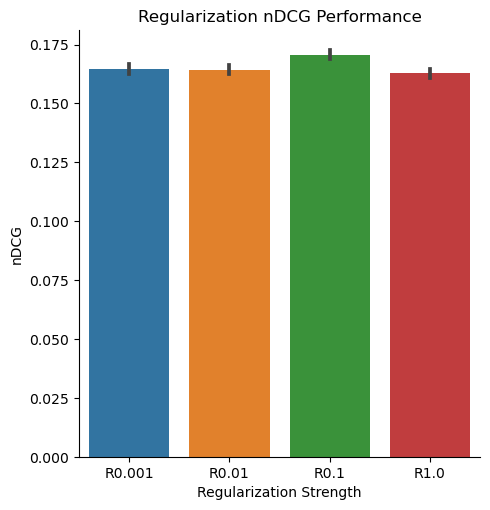

In [22]:
sns.color_palette("Set2")
sns.catplot(scores, x='algo', y='ndcg', kind='bar')
plt.xlabel('Regularization Strength')
plt.ylabel('nDCG')
plt.title('Regularization nDCG Performance')
plt.show()

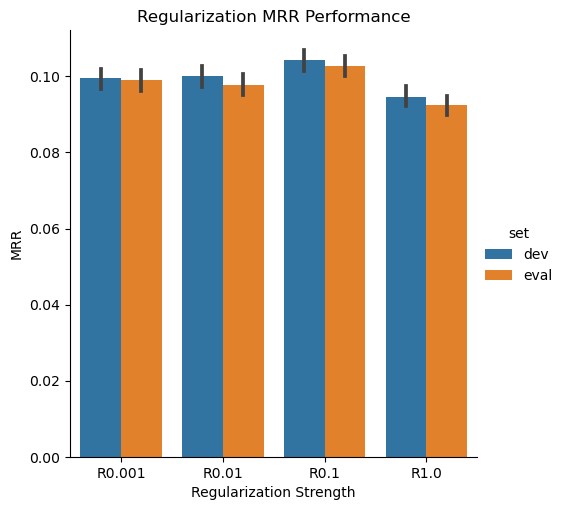

In [23]:
sns.catplot(scores, x='algo', y='recip_rank', hue='set', kind='bar')
plt.xlabel('Regularization Strength')
plt.ylabel('MRR')
plt.title('Regularization MRR Performance')
plt.show()

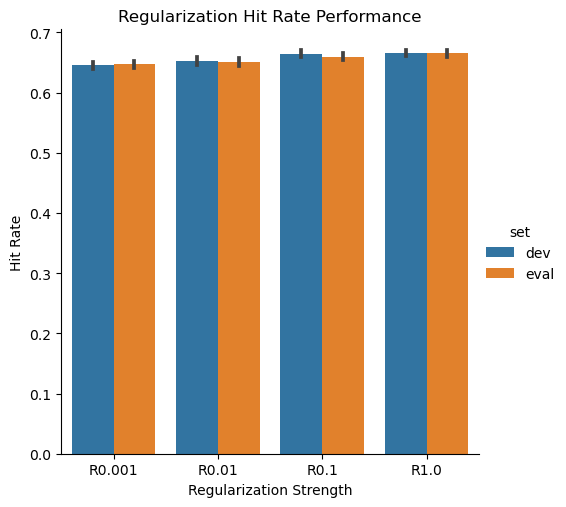

In [24]:
sns.catplot(scores, x='algo', y='hit', hue='set', kind='bar')
plt.xlabel('Regularization Strength')
plt.ylabel('Hit Rate')
plt.title('Regularization Hit Rate Performance')
plt.show()

For regularization, we can see that a strength of 0.1 seems to perform best in all but the hit rate.

#### Number of Features
Thrid, we will compare the number of feature. However, due to hardware constraints, my personal computer could not load any more than 70 features, so that will be the maximum number that we test.

In [25]:
recs = {}
_hy_re = re.compile(r'^hybrid-(.*)-(.*)-(dev|eval)\.parquet')
_algo_re = re.compile(r'^(.*)-(dev|eval)\.parquet')
for file in Path('recs_feat').glob('*.parquet'):
    hm = _hy_re.match(file.name)
    am = _algo_re.match(file.name)
    if hm:
        key = hm.group(1), hm.group(2), hm.group(3)
    elif am:
        key = am.group(1), 'NA', am.group(2)
    else:
        raise ValueError(f'bad name {file.name}')
    recs[key] = pd.read_parquet(file)

In [26]:
recs = pd.concat(recs, names=['algo', 'parts', 'set']).reset_index(['algo', 'parts', 'set']).reset_index(drop=True)
scores = rla.compute(recs, pd.concat([dev_test, eval_test], ignore_index=True), include_missing=True)
scores

nrecs  hit      ndcg  recip_rank  ntruth
algo parts set  user                                             
F10  NA    dev  6046878  100.0  1.0  0.135404    0.250000      13
                117918   100.0  0.0  0.000000    0.000000       1
                4665144  100.0  1.0  0.224244    0.045455       3
                3385905  100.0  0.0  0.000000    0.000000       1
                2896080  100.0  1.0  0.151861    0.010417       1
...                        ...  ...       ...         ...     ...
F70  NA    eval 6229490    0.0  NaN       NaN         NaN       3
                6229534    0.0  NaN       NaN         NaN       3
                6229876    0.0  NaN       NaN         NaN       3
                6230173    0.0  NaN       NaN         NaN       2
                6230389    0.0  NaN       NaN         NaN       2

[400000 rows x 5 columns]

In [27]:
scores = scores.reset_index()

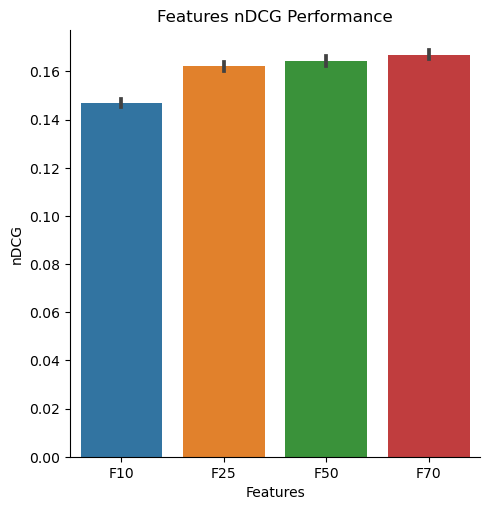

In [28]:
sns.color_palette("Set2")
sns.catplot(scores, x='algo', y='ndcg', kind='bar')
plt.xlabel('Features')
plt.ylabel('nDCG')
plt.title('Features nDCG Performance')
plt.show()

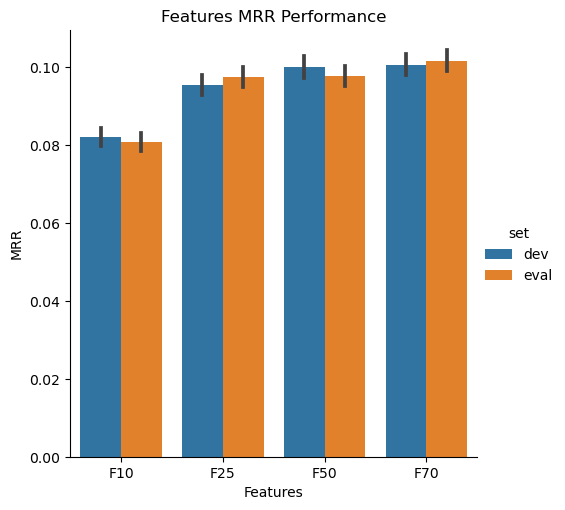

In [29]:
sns.catplot(scores, x='algo', y='recip_rank', hue='set', kind='bar')
plt.xlabel('Features')
plt.ylabel('MRR')
plt.title('Features MRR Performance')
plt.show()

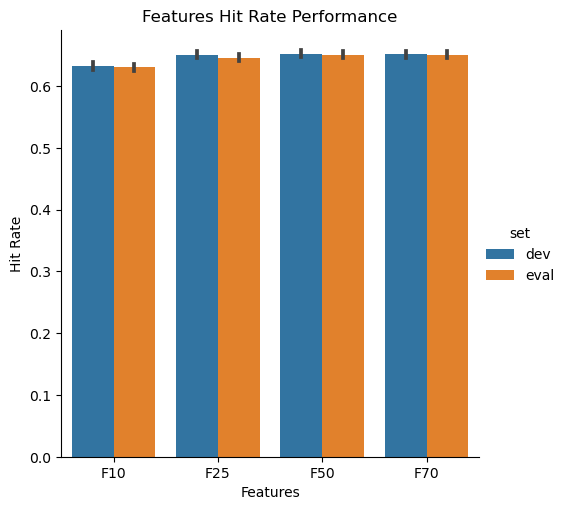

In [30]:
sns.catplot(scores, x='algo', y='hit', hue='set', kind='bar')
plt.xlabel('Features')
plt.ylabel('Hit Rate')
plt.title('Features Hit Rate Performance')
plt.show()

From the graphs we can see perfromance improves with more features. It does look like adding more features has somewhat diminishing returns, so we will stick with 70 features in our tuned model.

#### Content
Lastly, we want to see if adding the genres or developers has any affect on the performance as well by turning each component on one at a time.

In [31]:
recs = {}
_hy_re = re.compile(r'^hybrid-(.*)-(.*)-(dev|eval)\.parquet')
_algo_re = re.compile(r'^(.*)-(dev|eval)\.parquet')
for file in Path('recs_aba').glob('*.parquet'):
    hm = _hy_re.match(file.name)
    am = _algo_re.match(file.name)
    if hm:
        key = hm.group(1), hm.group(2), hm.group(3)
    elif am:
        key = am.group(1), 'NA', am.group(2)
    else:
        raise ValueError(f'bad name {file.name}')
    recs[key] = pd.read_parquet(file)

In [32]:
recs = pd.concat(recs, names=['algo', 'parts', 'set']).reset_index(['algo', 'parts', 'set']).reset_index(drop=True)
scores = rla.compute(recs, pd.concat([dev_test, eval_test], ignore_index=True), include_missing=True)
scores

nrecs  hit      ndcg  recip_rank  ntruth
algo   parts set  user                                             
base   NA    dev  6046878  100.0  1.0  0.086348    0.166667      13
                  117918   100.0  1.0  0.255958    0.066667       1
                  4665144  100.0  1.0  0.333333    0.125000       3
                  3385905  100.0  0.0  0.000000    0.000000       1
                  2896080  100.0  0.0  0.000000    0.000000       1
...                          ...  ...       ...         ...     ...
hybrid NA    eval 6229490    0.0  NaN       NaN         NaN       3
                  6229534    0.0  NaN       NaN         NaN       3
                  6229876    0.0  NaN       NaN         NaN       3
                  6230173    0.0  NaN       NaN         NaN       2
                  6230389    0.0  NaN       NaN         NaN       2

[400000 rows x 5 columns]

In [33]:
scores = scores.reset_index()

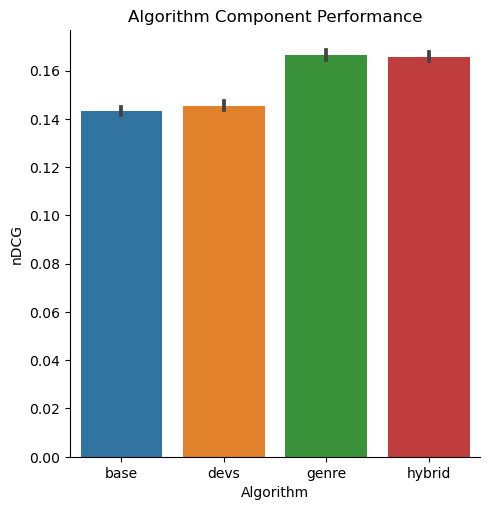

In [34]:
sns.color_palette("Set2")
sns.catplot(scores, x='algo', y='ndcg', kind='bar')
plt.xlabel('Algorithm')
plt.ylabel('nDCG')
plt.title('Algorithm Component Performance')
plt.show()

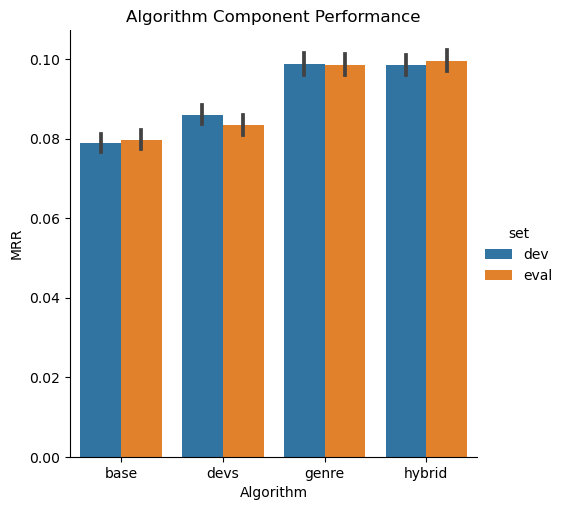

In [35]:
sns.catplot(scores, x='algo', y='recip_rank', hue='set', kind='bar')
plt.xlabel('Algorithm')
plt.ylabel('MRR')
plt.title('Algorithm Component Performance')
plt.show()

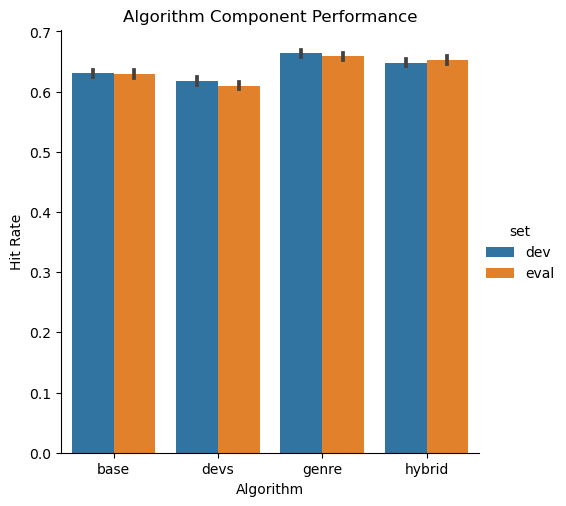

In [36]:
sns.catplot(scores, x='algo', y='hit', hue='set', kind='bar')
plt.xlabel('Algorithm')
plt.ylabel('Hit Rate')
plt.title('Algorithm Component Performance')
plt.show()

Since the devlopers does not cover all games in the dataset, it looks like it provides very little improvement from the base model. However, adding genres definetly provides better accuracy making it very close to the combined model. 

### Final Comparison

Since the hybrid model is now tuned using 70 features, 5 epochs, and 0.1 regularization, we can now evaluate it in comparison to the other algorithms.

In [7]:
recs = {}
_hy_re = re.compile(r'^hybrid-(.*)-(.*)-(dev|eval)\.parquet')
_algo_re = re.compile(r'^(.*)-(dev|eval)\.parquet')
for file in Path('recs').glob('*.parquet'):
    hm = _hy_re.match(file.name)
    am = _algo_re.match(file.name)
    if hm:
        key = hm.group(1), hm.group(2), hm.group(3)
    elif am:
        key = am.group(1), 'NA', am.group(2)
    else:
        raise ValueError(f'bad name {file.name}')
    recs[key] = pd.read_parquet(file)

In [8]:
recs = pd.concat(recs, names=['algo', 'parts', 'set']).reset_index(['algo', 'parts', 'set']).reset_index(drop=True)
recs

,algo,parts,set,item,score,user,rank
0,als,NA,dev,1817070,1.022360,6046878,1
1,als,NA,dev,638230,0.751450,6046878,2
2,als,NA,dev,289070,0.678516,6046878,3
3,als,NA,dev,221640,0.674147,6046878,4
4,als,NA,dev,1237320,0.660348,6046878,5
...,...,...,...,...,...,...,...
24999995,Tuned,NA,eval,1313140,-0.567897,568985,96
24999996,Tuned,NA,eval,1259420,-0.583333,568985,97
24999997,Tuned,NA,eval,323190,-0.586760,568985,98
24999998,Tuned,NA,eval,1466860,-0.600091,568985,99


#### Computing Metrics

In [39]:
scores = rla.compute(recs, pd.concat([dev_test, eval_test], ignore_index=True), include_missing=True)
scores

nrecs  hit      ndcg  recip_rank  ntruth
algo  parts set  user                                             
Tuned NA    dev  6046878  100.0  1.0  0.093111    0.125000      13
                 117918   100.0  1.0  0.224244    0.045455       1
                 4665144  100.0  1.0  0.315465    0.111111       3
                 3385905  100.0  0.0  0.000000    0.000000       1
                 2896080  100.0  1.0  0.155611    0.011628       1
...                         ...  ...       ...         ...     ...
pop   NA    eval 6229490    0.0  NaN       NaN         NaN       3
                 6229534    0.0  NaN       NaN         NaN       3
                 6229876    0.0  NaN       NaN         NaN       3
                 6230173    0.0  NaN       NaN         NaN       2
                 6230389    0.0  NaN       NaN         NaN       2

[500000 rows x 5 columns]

In [40]:
scores = scores.reset_index()

#### Results
**nDCG**

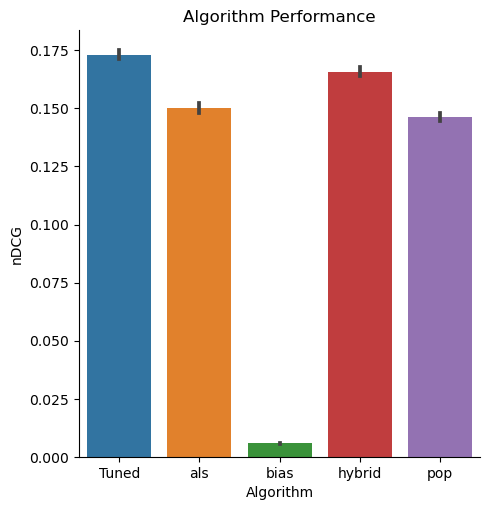

In [41]:
sns.color_palette("Set2")
sns.catplot(scores, x='algo', y='ndcg', kind='bar')
plt.xlabel('Algorithm')
plt.ylabel('nDCG')
plt.title('Algorithm Performance')
plt.show()

**MRR**

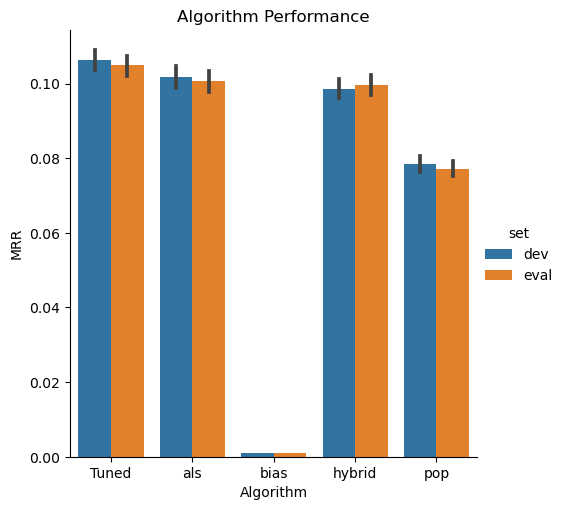

In [42]:
sns.catplot(scores, x='algo', y='recip_rank', hue='set', kind='bar')
plt.xlabel('Algorithm')
plt.ylabel('MRR')
plt.title('Algorithm Performance')
plt.show()

**Hit Rate**

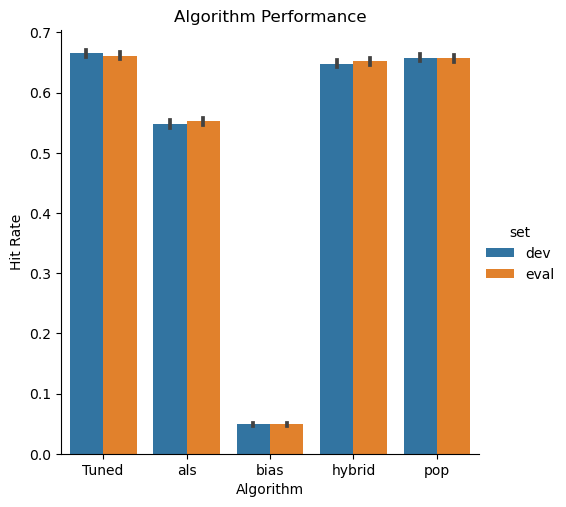

In [43]:
sns.catplot(scores, x='algo', y='hit', hue='set', kind='bar')
plt.xlabel('Algorithm')
plt.ylabel('Hit Rate')
plt.title('Algorithm Performance')
plt.show()

Altogether, the tuned hybridMF algorithm looks to be performing the best in all metrics. In contrast, Bias using the wieghted ratings looks to be performing the worst. This is possibly because the weighted scale may put too much emphasis on the hours played compared to whether the game is recommended or not.

In [33]:
metadata = pd.read_json('data/games_metadata.json', lines=True)
metadata = metadata.drop(['description'], axis=1)
metadata = metadata.rename(columns={'app_id':'item', 'tags':'genre'})

In [39]:
ratings = pd.read_parquet('data/ratings.parquet')
ratings = ratings[ratings['user'] == 6046878]
ratings = pd.merge(ratings, games, on='item', how='inner')
ratings = pd.merge(metadata, ratings, on='item', how='inner')

In [35]:
games = pd.read_csv('data/games.csv')
games = games[['app_id','title']]
games = games.rename(columns={'app_id':'item'})

In [36]:
user_recs = recs[recs['algo'] == 'Tuned']
user_recs = user_recs[user_recs['user'] == 6046878]
user_recs = pd.merge(user_recs, games, on='item', how='inner')
user_recs = pd.merge(user_recs, metadata, on='item', how='inner')

In [37]:
user_recs

,algo,parts,set,item,score,user,rank,title,genre
0,Tuned,NA,dev,225540,4.593040,6046878,1,Just Cause™ 3,"[Open World, Action, Destruction, Third-Person..."
1,Tuned,NA,dev,271590,4.531921,6046878,2,Grand Theft Auto V,"[Open World, Action, Multiplayer, Crime, Autom..."
2,Tuned,NA,dev,477160,4.012294,6046878,3,Human: Fall Flat,"[Co-op, Funny, Puzzle, Adventure, Physics, San..."
3,Tuned,NA,dev,1174180,3.603474,6046878,4,Red Dead Redemption 2,"[Open World, Story Rich, Adventure, Western, A..."
4,Tuned,NA,dev,431960,3.571382,6046878,5,Wallpaper Engine,"[Mature, Utilities, Software, Anime, Design & ..."
...,...,...,...,...,...,...,...,...,...
95,Tuned,NA,dev,501300,0.659129,6046878,96,What Remains of Edith Finch,"[Story Rich, Atmospheric, Walking Simulator, F..."
96,Tuned,NA,dev,1089980,0.654904,6046878,97,The Henry Stickmin Collection,"[Funny, Multiple Endings, Choose Your Own Adve..."
97,Tuned,NA,dev,690790,0.640367,6046878,98,DiRT Rally 2.0,"[Racing, Automobile Sim, Simulation, Multiplay..."
98,Tuned,NA,dev,1092790,0.627474,6046878,99,Inscryption,"[Card Battler, Card Game, Story Rich, Deckbuil..."


In [40]:
ratings

,item,genre,user,rating,title
0,524220,"[Great Soundtrack, Story Rich, Female Protagon...",6046878,2,NieR:Automata™
1,854940,"[Indie, RPG, LGBTQ+, Female Protagonist, Pixel...",6046878,2,Ikenfell
2,9900,"[Free to Play, Sci-fi, Massively Multiplayer, ...",6046878,0,Star Trek Online
3,334940,"[Pinball, Metroidvania, Adventure, Platformer,...",6046878,3,Yoku's Island Express
4,774361,"[Metroidvania, Pixel Graphics, Souls-like, Gor...",6046878,3,Blasphemous
5,1222140,"[Choices Matter, Story Rich, Multiple Endings,...",6046878,3,Detroit: Become Human
6,851670,"[Casual, Indie, Puzzle, Music, Great Soundtrac...",6046878,5,LUMINES REMASTERED
7,233740,"[Zombies, Indie, Retro, Strategy, Post-apocaly...",6046878,2,Organ Trail: Director's Cut
8,424840,"[Horror, Atmospheric, Adventure, Singleplayer,...",6046878,3,Little Nightmares
9,916730,"[Indie, Metroidvania, Action, Adventure, Pixel...",6046878,3,Gato Roboto
